<a href="https://colab.research.google.com/github/AshAninze/Uni-Projects/blob/main/Tumour_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [521]:
from keras import backend as K #importing the Keras backed module as K - easier to refer back to
from keras.models import Sequential # linear stack of layers for building simple NN
from keras.layers import Conv2D # 2D Conv layer for image processing
from keras.layers import MaxPooling2D # max pooling for downsampling
from keras.layers import Activation #activation functions like ReLu
from tensorflow.keras.layers import Dropout #deactives neuros to reduce overfitting
from keras.layers import Flatten # flattens multi-dimensional inputs to 1D
from keras.layers import Dense # fully connected layer, used for classification
from keras.utils import to_categorical # concerts class labels to one hot encoded vectors
from keras.optimizers import SGD, RMSprop, Adam #optimization algorithms
import numpy as np #math operations
import matplotlib.pyplot as plt #plotting library
import tensorflow as tf #deeping learning framework
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data augmentation and loading images


In [522]:
#the purpose of this code is to create a new validation folder by selecting a random 20% of the testing and training folder
import os #for constructing file paths - interacting with operator system
import random #randomiser
import shutil  # For file operations copying moving

'''val_ratio = 0.2 #assigning the validation split
val_dir = '/content/drive/MyDrive/Colab Notebooks/Neural Networks/Validation' #new directory for validation

for data_dir in [train, test]:  # Iterate over both training and testing folders
    class_dirs = os.listdir(data_dir) #gets the list of subdir
    for class_name in class_dirs: #iterates over class folder
        class_path = os.path.join(data_dir, class_name) #creates full path to class folder
        image_files = os.listdir(class_path) #list of all image file in class folder
        val_size = int(len(image_files) * val_ratio) #calualtes how many more images till 20%
        val_images = random.sample(image_files, val_size) #randomly select files

        # move selected images to the validation folder
        for image_name in val_images: #iterates over val images
            src_path = os.path.join(class_path, image_name) #creates path of orginal image
            dst_path = os.path.join(val_dir, class_name, image_name) #creates destination path of new location
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Create class subdir
            shutil.move(src_path, dst_path) #move files between directories'''


"val_ratio = 0.2 #assigning the validation split\nval_dir = '/content/drive/MyDrive/Colab Notebooks/Neural Networks/Validation' #new directory for validation\n\nfor data_dir in [train, test]:  # Iterate over both training and testing folders\n    class_dirs = os.listdir(data_dir) #gets the list of subdir\n    for class_name in class_dirs: #iterates over class folder\n        class_path = os.path.join(data_dir, class_name) #creates full path to class folder\n        image_files = os.listdir(class_path) #list of all image file in class folder\n        val_size = int(len(image_files) * val_ratio) #calualtes how many more images till 20%\n        val_images = random.sample(image_files, val_size) #randomly select files\n\n        # move selected images to the validation folder\n        for image_name in val_images: #iterates over val images\n            src_path = os.path.join(class_path, image_name) #creates path of orginal image\n            dst_path = os.path.join(val_dir, class_name, im

## Data Preprocessing

In [636]:
#providing the directories where the data is located
test = ('/content/drive/MyDrive/Colab Notebooks/Neural Networks/Testing')
train = ('/content/drive/MyDrive/Colab Notebooks/Neural Networks/Training')
val = ('/content/drive/MyDrive/Colab Notebooks/Neural Networks/Validation')

code below was provided by  (Md Shahbaz Alam, 2023)

In [637]:
#this code is augmenting the training data, the purpose is to diverify the images by rotatation, flips etc. to make the model more robust and less prone to overfitting
train_datagen = ImageDataGenerator( #
    rescale=1./255, #normalised pixels from orginal range (0-255) to a range of 0-1
    rotation_range=5, #rotaion range up to 10
    width_shift_range=0.2, #width shift up to 20%
    height_shift_range=0.2, #height shift up to 20%
    shear_range=0.2, # tilting image up to 20%
    zoom_range=0.2, # zoom in or out on image up to 20%
    horizontal_flip=True, #randonly flips images horizontally (mirror)
    brightness_range=[0.95, 1.05], # changes the brightness 90 - 110% of the original
    #channel_shift_range=20, #changes the RBG channel up to 20 units
    fill_mode='nearest' #when new pixels are introduces this sets then to the nearest pixel
)

# only rescaling val and test to not effect performance rates
val_datagen = ImageDataGenerator(rescale=1./255) # same rescale values to remain consistent
test_datagen = ImageDataGenerator(rescale=1./255)

applying data generation

In [638]:
#purpose of this code is to load, preprocess and augment data in batches
train_generator = train_datagen.flow_from_directory( #loading images from directory and applies transformations defined in train_datagen
    train, #dir of train
    target_size=(224,224), #resizing image to 224x224 for consistency
    batch_size=16, #how many images that will be created at a time
    class_mode='categorical', #one hot encoding labels for categorical labels
    shuffle = False
)

Found 4571 images belonging to 4 classes.


In [639]:
val_generator = val_datagen.flow_from_directory(#loading images from directory and applies transformations defined in val_datagen
    val, #dir of val
    target_size=(224,224), #resizing image to 224x224 for consistency
    batch_size=16, #how many images that will be created at a time
    class_mode='categorical', #one hot encoding labels for categorical labels
    shuffle = False
)

Found 1403 images belonging to 4 classes.


In [640]:
test_generator = test_datagen.flow_from_directory(#loading images from directory and applies transformations defined in test_datagen
    test, #dir of test
    target_size=(224,224), #resizing image to 224x224 for consistency
    batch_size=16, #how many images that will be created at a time
    class_mode='categorical', #one hot encoding labels for categorical labels
    shuffle = False
)

Found 1049 images belonging to 4 classes.


## CNN Model


In [627]:
from tensorflow.keras.layers import GlobalAveragePooling2D #imports layer to reduce spatial dimensions
from tensorflow.keras.models import Model #import model class for building custom models
from tensorflow.keras.layers import BatchNormalization #importing batchnormalization
from tensorflow.keras.regularizers import l1_l2 #elasticnet


#the goal of this code is to create a cnn model using transfer learning on xception model, adapting it to fit 4 classes
# retrained the top layers to fit model to my needs

base_model = tf.keras.applications.Xception( #This load xception model pre trained on imagenet dataset
    include_top=False,  # removes the original top classification layer since it was original trained for 1000 classes
    weights='imagenet', # loads the weights from imagenet
    input_shape=(224, 224, 3)  # setting my input image size with 3 colour channels
)

# freeze the base model layers to avoid training them to be able to use the existing knowledge
base_model.trainable = False

# creating of my own classification layer
x = base_model.output #outputs from xception model
x = GlobalAveragePooling2D()(x)  #reduces spatial dimension of the feature map to a single vector
x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2 = 0.0001))(x)  #adds a dense layer with 128 neurons and ReLU activation func - allows model to learn complex relationships - elasticnet used to combine both lasso and ridge
#x = BatchNormalization()(x) #normalization techique to normalize activation layers making it more stable
x = Dropout(0.3)(x) #dropout layer with 40% to reduce over fitting
predictions = Dense(4, activation='softmax')(x)  #final output layer representing 4 classes softmax activation function to ensure output is a prob dist over the classes

model = Model(inputs=base_model.input, outputs=predictions) #combines xception model with my custom layer to create model


In [628]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #call back classes

#monitoring validation loss and stopping the model when the metric does not improve - this is to stop overfitting

early_stopping = EarlyStopping( #creating earlystopping
    monitor='val_loss',  # monitoring validation loss
    patience=2,          # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # restore model's weights from the epoch with the best val_loss
)

# model checkpoint to save the best model
checkpoint = ModelCheckpoint( #saves the weight of the best performance
    '/content/drive/MyDrive/Colab Notebooks/Neural Networks/best_model.h5', #file name
    monitor='val_loss', #monitoring val loss
    save_best_only=True, #setting to ensure model is saved
    mode='min', #want to save only the the best performance
    verbose=1 #message will be printed each time
)

In [629]:
#optimisation stratergy
from tensorflow.keras.optimizers import SGD #importing stochastic gradient decent
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

#adding an optimizer and comiling the code
#learning_rate = 0.0001 #setting the learning rate - controls the weight updates - small value for pretrained model
#momentum = 0.8 #momentum - helps optimizer accelerate in the right direction
#decay_rate = 0.96
#decay_steps = 1500 #1/10th of the total steps (143*20)*.1

#lr_schedule = ExponentialDecay(learning_rate, decay_steps, decay_rate)
#OPTIMIZER = SGD(learning_rate=learning_rate, momentum=momentum) #calling the SGD optimizer
OPTIMIZER = Adam(learning_rate=0.002)

#configuring the models learning process
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy']) #loss function and accuracy metric during training

In [630]:
model.summary() #provides infomation on the models architecture

Model: "model_87"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_87 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_87[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [631]:
#fitting the model
history = model.fit( #fitting the model and labeling it history to be able to visulise the results
    train_generator, #augmented training data
    epochs=40, #defining epochs
    validation_data=val_generator, #val data
    callbacks=[early_stopping, checkpoint] #callbacks
)

Epoch 1/40
286/286 [==============================] - ETA: 0s - loss: 1.2337 - accuracy: 0.6355
Epoch 1: val_loss improved from inf to 0.73817, saving model to /content/drive/MyDrive/Colab Notebooks/Neural Networks/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 125s 424ms/step - loss: 1.2337 - accuracy: 0.6355 - val_loss: 0.7382 - val_accuracy: 0.7627
Epoch 2/40
286/286 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.7624
Epoch 2: val_loss improved from 0.73817 to 0.61107, saving model to /content/drive/MyDrive/Colab Notebooks/Neural Networks/best_model.h5
286/286 [==============================] - 122s 425ms/step - loss: 0.7761 - accuracy: 0.7624 - val_loss: 0.6111 - val_accuracy: 0.8275
Epoch 3/40
286/286 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.8132
Epoch 3: val_loss improved from 0.61107 to 0.51861, saving model to /content/drive/MyDrive/Colab Notebooks/Neural Networks/best_model.h5
286/286 [==============================] - 122s 426ms/step - loss: 0.6556 - accuracy: 0.8132 - val_loss: 0.5186 - val_accuracy: 0.8574
Epoch 4/40
286/286 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.8123
Epoch 4: val_loss did not improve

In [653]:
#vggnet 16 model for comparison
from tensorflow.keras.applications import VGG16 #importing vgg16 model
from tensorflow.keras.layers import Input # to define the input shape for the model
# Load the model with ImageNet weights (for transfer learning) anf freezing the layer to save the knowledge

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3))) #defining the shape and weighting
x = base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)  # classification layers
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model.fit(train_generator, epochs=10, validation_data=val_generator)



Epoch 1/10
286/286 [==============================] - 79s 272ms/step - loss: 1.3378 - accuracy: 0.3846 - val_loss: 1.1807 - val_accuracy: 0.5638
Epoch 2/10
286/286 [==============================] - 78s 272ms/step - loss: 1.1348 - accuracy: 0.5913 - val_loss: 1.0751 - val_accuracy: 0.5331
Epoch 3/10
286/286 [==============================] - 78s 273ms/step - loss: 1.0117 - accuracy: 0.6465 - val_loss: 0.9603 - val_accuracy: 0.6757
Epoch 4/10
286/286 [==============================] - 78s 272ms/step - loss: 0.9394 - accuracy: 0.6738 - val_loss: 0.8709 - val_accuracy: 0.7420
Epoch 5/10
286/286 [==============================] - 78s 272ms/step - loss: 0.8806 - accuracy: 0.7068 - val_loss: 0.8283 - val_accuracy: 0.7306
Epoch 6/10
286/286 [==============================] - 77s 270ms/step - loss: 0.8336 - accuracy: 0.7095 - val_loss: 0.7948 - val_accuracy: 0.7455
Epoch 7/10
286/286 [==============================] - 77s 268ms/step - loss: 0.7923 - accuracy: 0.7274 - val_loss: 0.7731 - val_ac

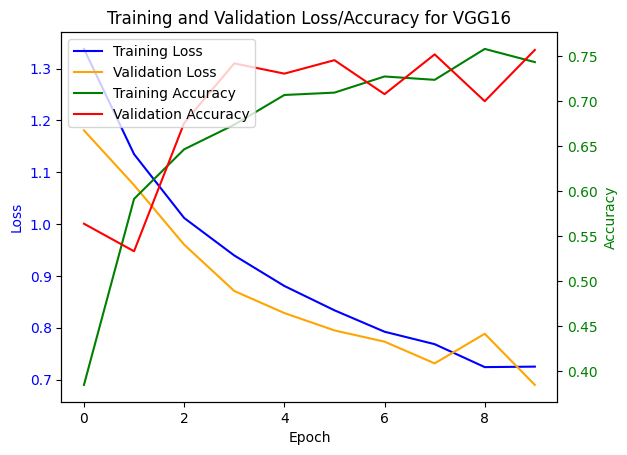

In [654]:
import matplotlib.pyplot as plt
#training/validation loss compared with accuracy

# Create subplots for better organization
fig, ax1 = plt.subplots()

# Plot the loss curves (use a different color for validation loss)
ax1.plot(history1.history['loss'], label='Training Loss', color='blue') #plotting the training loss value over epochs
ax1.plot(history1.history['val_loss'], label='Validation Loss', color='orange')#plotting the validation loss value over epochs
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()

# Plot accuracy curves (use a different color for validation accuracy)
ax2.plot(history1.history['accuracy'], label='Training Accuracy', color='green')#plotting the training accuracy value over epochs
ax2.plot(history1.history['val_accuracy'], label='Validation Accuracy', color='red')#plotting the validation accuracy value over epochs
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends from both axis
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Training and Validation Loss/Accuracy for VGG16')
plt.show()


## Visualisation

In [620]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Neural Networks/best_model.h5')


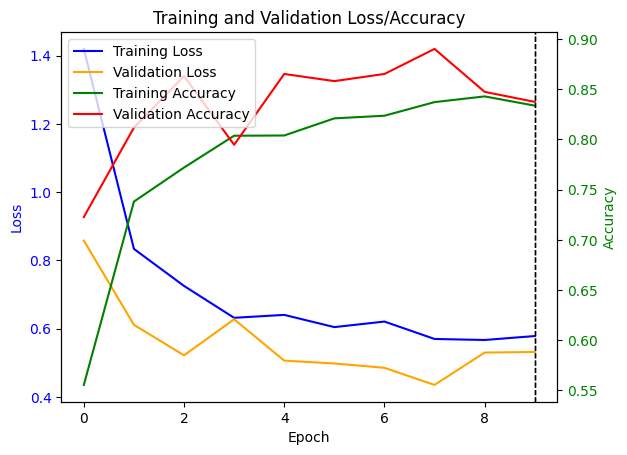

In [606]:
import matplotlib.pyplot as plt
#training/validation loss compared with accuracy on one graph

# reate subplots for organisation
fig, ax1 = plt.subplots()

# Plot the loss curves - different colour for each line for readability
ax1.plot(history.history['loss'], label='Training Loss', color='blue') #plotting the training loss value over epochs as a blue line
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')#plotting the validation loss value over epochs as an orange line
ax1.set_xlabel('Epoch') #x axis set to epoch
ax1.set_ylabel('Loss', color='blue') #y axis set to loss
ax1.tick_params(axis='y', labelcolor='blue') #y axis blue for training loss

# create a second y-axis for accuracy
ax2 = ax1.twinx()

# plot accuracy curves (use a different color for validation accuracy)
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='green')#plotting the training accuracy value over epochs
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')#plotting the validation accuracy value over epochs
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green') #y axis green for training accuracy

# combine legends from both axis
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left') #created legend in top left corner

# mark the early stopping epoch if it occurred
if early_stopping.stopped_epoch > 0: #checks if early stopping was triggered
    ax1.axvline(x=early_stopping.stopped_epoch, color='black', linestyle='dashed', linewidth=1) #creates a dashed line where early stopping occured
    ax2.axvline(x=early_stopping.stopped_epoch, color='black', linestyle='dashed', linewidth=1)

plt.title('Training and Validation Loss/Accuracy')
plt.show()


In [608]:
loss, accuracy = best_model.evaluate(test_generator) # calulating loss and accuracy for plotting
print("Test Loss:", loss) #prints loss value
print("Test Accuracy:", accuracy) #prints accuracy value



66/66 [==============================] - 6s 78ms/step - loss: 0.4846 - accuracy: 0.8656
Test Loss: 0.4845634996891022
Test Accuracy: 0.8655862808227539


In [610]:
from sklearn.metrics import confusion_matrix, classification_report #imorting classication report and confusion matrix
import seaborn as sns #data visulisation library

y_true = test_generator.classes  # Extract true labels from the generator
y_pred = np.argmax(best_model.predict(test_generator), axis=-1) #get predicted labels of the highest probability
conf_matrix = confusion_matrix(y_true, y_pred) #printing out confusion matrix
print('Confusion Matrix:') #prints out confusion matrix
print(conf_matrix)


66/66 [==============================] - 6s 70ms/step
Confusion Matrix:
[[189  47   0   4]
 [ 22 178  21  24]
 [  3   7 314   0]
 [  2  11   0 227]]


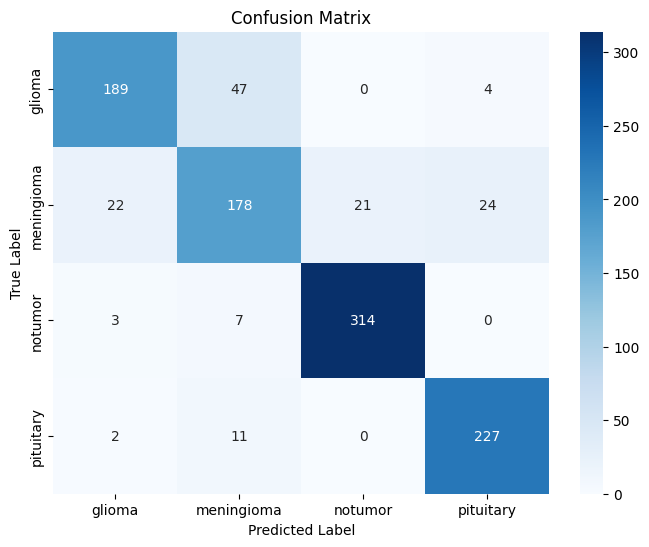


Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.79      0.83       240
  meningioma       0.73      0.73      0.73       245
     notumor       0.94      0.97      0.95       324
   pituitary       0.89      0.95      0.92       240

    accuracy                           0.87      1049
   macro avg       0.86      0.86      0.86      1049
weighted avg       0.86      0.87      0.86      1049



In [611]:
#creating a confusion matrix for xception model
class_names = list(test_generator.class_indices.keys())  # Get class names
plt.figure(figsize=(8, 6))  # adjust plot size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) #visualising the calulated confusion matrix in whole numbers
plt.xlabel('Predicted Label') #setting labels for x and y
plt.ylabel('True Label')
plt.title('Confusion Matrix') #title
plt.show()

# calculate and print report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))